In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.feature_selection import f_classif

%matplotlib inline

In [2]:
DATASET_PATH = 'sensor'
META_FP = os.path.join(DATASET_PATH, 'demographics.txt')
RANDOM_SEED = 0

In [3]:
def read_meta(fp: str) -> pd.DataFrame:
    with open(fp, 'r') as fobj:
        col_line = fobj.readline().strip()
        
        data = {}
        cols = []
        for col in col_line.split():
            data[col] = []
            cols.append(col)
        for line in fobj.readlines():
            for i, val_str in enumerate(line.strip().split()):
                val = None
                try:
                    val = float(val_str)
                except ValueError:
                    val = val_str
                data[cols[i]].append(val)
        return pd.DataFrame(data)
meta_df = read_meta(META_FP)

In [4]:
meta_df['HoehnYahr'].isna().sum()

55

In [5]:
IGNORE_FN = ['format.txt', 'demographics.txt']
datasets = {}
valid_ds_types = ['ga', 'ju', 'si']
valid_label_types = ['co', 'pt']
for fn in os.listdir(DATASET_PATH):
    if fn in IGNORE_FN:
        continue
        
    dataset_type = fn[:2].lower()
    label_enc = fn[2:4].lower()
    if (dataset_type not in valid_ds_types) or (label_enc not in valid_label_types):
        continue
    if dataset_type not in datasets:
        datasets[dataset_type] = {'data': [], 'labels': []}
        
    timeseries = []
    
    with open(os.path.join(DATASET_PATH, fn), 'r') as fobj:
        for i, line in enumerate(fobj.readlines()):
            measurements = line.strip().split()
            try:
                measurements = list(map(lambda reading: float(reading), measurements[:17]))
                timeseries.append(measurements)
            except:
                print(fn)
                print(i + 1)
                print(line)
        
        timeseries = np.array(timeseries).T
        datasets[dataset_type]['data'].append(timeseries)
        if label_enc == 'co':
            datasets[dataset_type]['labels'].append(0)
        elif label_enc == 'pt':
            datasets[dataset_type]['labels'].append(1)

In [6]:
for k1 in datasets.keys():
    datasets[k1]['labels'] = np.array(datasets[k1]['labels'])

In [7]:
data = []
labels = []

import warnings
warnings.filterwarnings("error")

for dataset in datasets.values():
    data += dataset['data']
    labels.append(dataset['labels'])
y = np.concatenate(labels)

In [9]:
data[0].shape

(17, 12119)

In [10]:
lens = list(map(lambda seq: seq.shape[1], data))

In [11]:
print(max(lens))
print(min(lens))

26366
4034


In [12]:
def find_pattern_location(timestamps, trough_indices, time_th = .3, start = True):
    time_differences = np.diff(timestamps[trough_indices])
    if not start:
        time_differences = np.flip(time_differences)
    idx_iter = range(trough_indices.shape[0] - 1) if start else range(trough_indices.shape[0] - 1, 0, -1)
    
    pattern_indices = []
    for idx, time_diff in zip(idx_iter, time_differences):
        if time_diff > time_th:
            pattern_indices.append(trough_indices[idx])
            
    pattern_indices = np.array(pattern_indices, dtype=np.int64)
    return pattern_indices if start else np.flip(pattern_indices)

def merge_sorted_arrays(arr1, arr2):
    i: int = 0
    j: int = 0
    n1 = len(arr1)
    n2 = len(arr2)
    
    sorted_arr = []
    while i < n1 and j < n2:
        if arr1[i] < arr2[j]:
            sorted_arr.append(arr1[i])
            i += 1
        else:
            sorted_arr.append(arr2[j])
            j += 1
    while i < n1:
        sorted_arr.append(arr1[i])
        i += 1
    while j < n2:
        sorted_arr.append(arr2[j])
        j += 1
        
    return np.array(sorted_arr, dtype=np.int64)

def get_pattern_indices(measurements, timestamps, TROUGH_TH = 2):
    trough_indices = (measurements < TROUGH_TH).nonzero()[0]
            
    pattern_start_indices = find_pattern_location(timestamps, trough_indices, start=True)
    pattern_end_indices = find_pattern_location(timestamps, trough_indices, start=False)
    return merge_sorted_arrays(pattern_start_indices, pattern_end_indices)

def get_on_and_off_ground_indices_from_pattern_indices(measurements, pattern_indices):
    off_ground_indices = []
    on_ground_indices = []
    for i in range(1, len(pattern_indices)):
        force = measurements[pattern_indices[i-1]: pattern_indices[i]].sum()
        if force < 50:
            off_ground_indices.append((pattern_indices[i-1], pattern_indices[i]))
        else:
            on_ground_indices.append((pattern_indices[i-1], pattern_indices[i]))
    return off_ground_indices, on_ground_indices

def visualize_troughs(sample, sensor_idx, total_nb_timestamps: int = -1):
    plt.figure()
    measurements = sample[sensor_idx, :total_nb_timestamps] if total_nb_timestamps > 0 else sample[sensor_idx]
    timestamps = sample[0, :total_nb_timestamps] if total_nb_timestamps > 0 else sample[0]

    pattern_indices = get_pattern_indices(measurements, timestamps)
    trough_timestamps = timestamps[pattern_indices] 

    plt.plot(timestamps, measurements)
    plt.scatter(trough_timestamps, np.zeros_like(trough_timestamps))
    plt.title(f'Sensor ID: {sensor_idx}')
    plt.show()

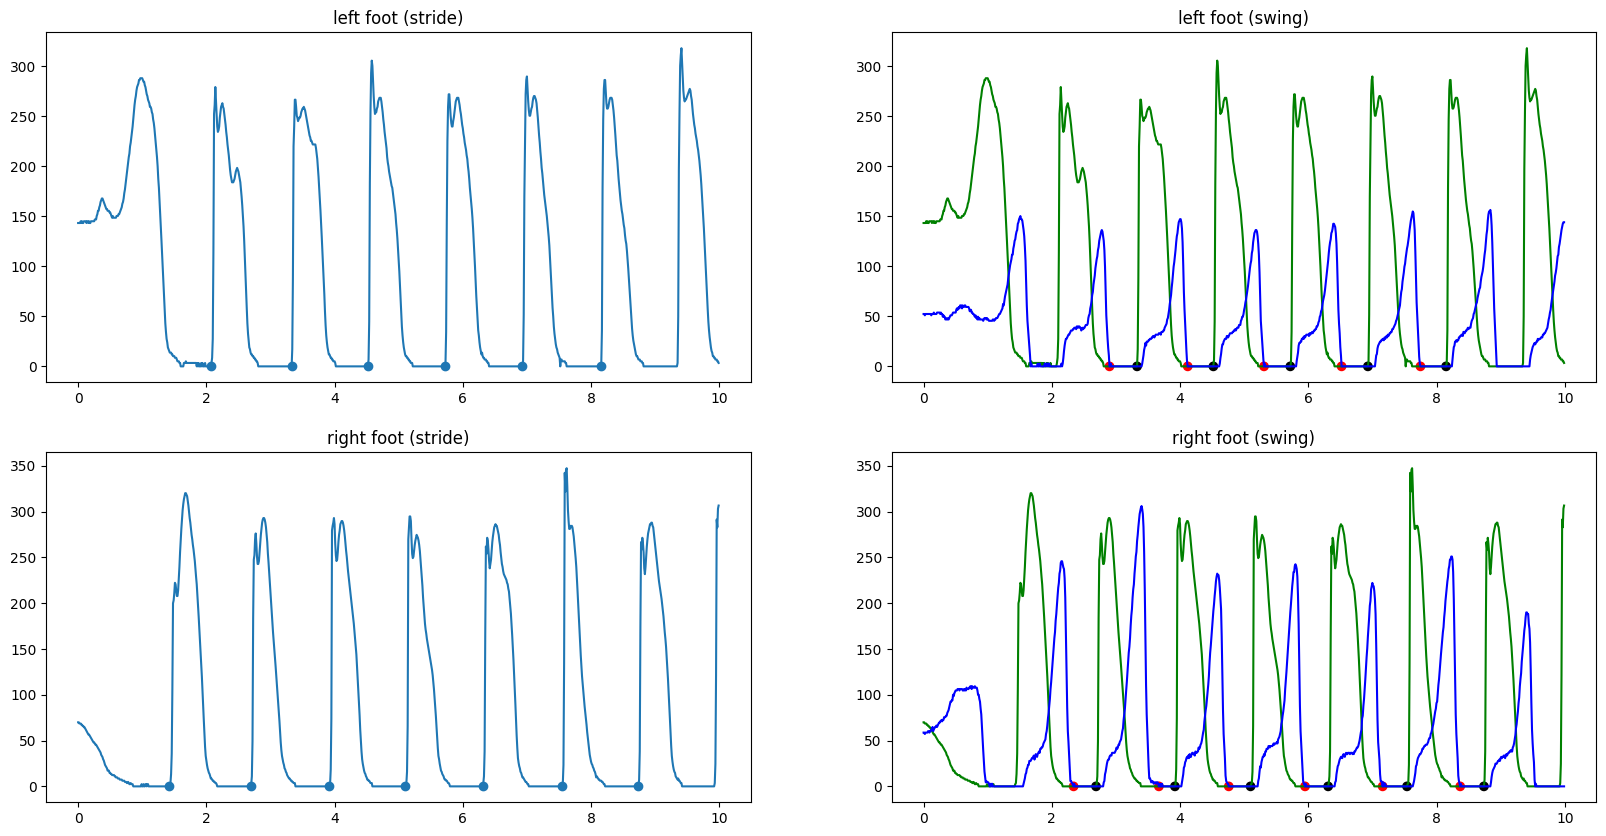

In [13]:
def extract_stride_times(measurements, timestamps):
    pattern_indices = get_pattern_indices(measurements, timestamps)
    _, on_ground_indices = get_on_and_off_ground_indices_from_pattern_indices(measurements, 
                                                                            pattern_indices)
    stride_times = []
    for i in range(1, len(on_ground_indices)):
        stride_times.append(timestamps[on_ground_indices[i][0]] - timestamps[on_ground_indices[i-1][0]])
    return np.array(stride_times)


def get_swing_indices(heel_measurements, toe_measurements, timestamps):
    heel_pattern_indices = get_pattern_indices(heel_measurements, timestamps)
    _, heel_on_ground_indices = get_on_and_off_ground_indices_from_pattern_indices(heel_measurements, 
                                                                                    heel_pattern_indices)
    
    toe_pattern_indices = get_pattern_indices(toe_measurements, timestamps)
    toe_off_ground_indices, _ = get_on_and_off_ground_indices_from_pattern_indices(toe_measurements, 
                                                                                    toe_pattern_indices)
    
    i: int = 0
    swing_indices = []
    for initial_swing_idx, _ in toe_off_ground_indices:
        while i < len(heel_on_ground_indices) and heel_on_ground_indices[i][0] < initial_swing_idx:
            i += 1
        if i == len(heel_on_ground_indices):
            break
        else:
            terminal_swing_idx = heel_on_ground_indices[i][0]
            swing_indices.append((initial_swing_idx, terminal_swing_idx))
    return swing_indices
            

def extract_swing_times(heel_measurements, toe_measurements, timestamps):
    swing_times = [timestamps[terminal_swing_idx] - timestamps[initial_swing_idx] 
                            for initial_swing_idx, terminal_swing_idx in get_swing_indices(heel_measurements, 
                                                                                           toe_measurements, 
                                                                                           timestamps)]
    return np.array(swing_times)


def visualize_sample_features(sample, nb_readings: int = 1000):
    timestamps = sample[0, :nb_readings]
    
    heel_toe_indices = [(1, 8), (9, 16)]
    foot_order = ['left', 'right']
    
    fig, axes = plt.subplots(2, 2)
    fig.set_figheight(10)
    fig.set_figwidth(20)
    
    i: int = 0
    for i, (heel_idx, toe_idx) in enumerate(heel_toe_indices):
        pattern_indices = get_pattern_indices(sample[heel_idx, :nb_readings], timestamps)
        _, on_ground_indices = get_on_and_off_ground_indices_from_pattern_indices(sample[heel_idx, :nb_readings], 
                                                                            pattern_indices)
        swing_indices = get_swing_indices(sample[heel_idx, :nb_readings], sample[toe_idx, :nb_readings], timestamps)
        
        
        heel_contact_timestamps = np.array([timestamps[heel_contact_idx] for heel_contact_idx, _ in on_ground_indices])
        
        swing_timestamps = [] 
        for initial_swing_idx, terminal_swing_idx in swing_indices:
            swing_timestamps.append(timestamps[initial_swing_idx])
            swing_timestamps.append(timestamps[terminal_swing_idx])
            
        swing_timestamps = np.array(swing_timestamps)
        
        
        axes[i, 0].set_title(f'{foot_order[i]} foot (stride)')
        axes[i, 0].plot(timestamps, sample[heel_idx, :nb_readings])
        axes[i, 0].scatter(heel_contact_timestamps, np.zeros_like(heel_contact_timestamps))
        
        axes[i, 1].set_title(f'{foot_order[i]} foot (swing)')
        axes[i, 1].plot(timestamps, sample[heel_idx, :nb_readings], color='green')
        axes[i, 1].plot(timestamps, sample[toe_idx, :nb_readings], color='blue')
        
        swing_labels = ['red', 'black'] * (len(swing_timestamps) // 2)
        if len(swing_timestamps) != len(swing_labels):
            swing_labels.append('red')
            
        axes[i, 1].scatter(swing_timestamps, np.zeros_like(swing_timestamps), color=swing_labels)
        
np.seterr(all='raise')


def extract_features(data):
    features = []
    removed_indices = []
    for i, sample in enumerate(data):
        timestamps = sample[0]
        
        try:
            left_stride_times = extract_stride_times(sample[1], timestamps)
            right_stride_times = extract_stride_times(sample[9], timestamps)
            
            left_swing_times = extract_swing_times(sample[1], sample[8], timestamps)
            right_swing_times = extract_swing_times(sample[9], sample[16], timestamps)
            
            
            features.append([left_stride_times.mean(), left_stride_times.std(), right_stride_times.mean(), right_stride_times.std(),
                            left_swing_times.mean(), left_swing_times.std(), right_swing_times.mean(), right_swing_times.std()])
            # features.append([left_stride_times.mean(), left_stride_times.std(), right_stride_times.mean(), right_stride_times.std()])
        except Exception as e:
            print(e)
            removed_indices.append(i)
            # visualize_troughs(sample, 9, -1)
        
    return np.array(features), removed_indices

visualize_sample_features(data[7])

In [14]:
X, removed_indices = extract_features(data)
y = np.delete(y, removed_indices)

Mean of empty slice.
Mean of empty slice.


In [26]:
(y_train == 1).sum()

170

In [16]:
removed_indices

[65, 97]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RANDOM_SEED)
del X, y

In [16]:
class_weight = {i: (y_train.shape[0] / nb_samples) for i, nb_samples in zip(*np.unique(y_train, return_counts=True))}

# Comment out below two lines if class-weighing is desired
# class_weight[0] = 1
# class_weight[1] = 1

print(class_weight)

{0: 3.328767123287671, 1: 1.4294117647058824}


In [17]:
PCA_NB_COMP = None
if PCA_NB_COMP is not None:
    pca = PCA(n_components=PCA_NB_COMP, random_state=RANDOM_SEED)
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)

In [18]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
def calc_metrics(model, X, y):
    y_pred = model.predict(X)
    
    metrics = {}
    
    metrics['acc'] = model.score(X, y)
    
    # conf_mat = confusion_matrix(y, y_pred)
    # metrics['tn'] = conf_mat[0][0]
    # metrics['fp'] = conf_mat[0][1]
    # metrics['fn'] = conf_mat[1][0]
    # metrics['tp'] = conf_mat[1][1]
    
    metrics['prec'], metrics['recall'], metrics['f1'], _ = precision_recall_fscore_support(y, y_pred, average='binary')
    
    # metrics['auc'] = roc_auc_score(y, model.predict_proba(X)[:, 1])
    
    return metrics

In [20]:
models = {
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_SEED, class_weight=class_weight),
    'Random Forest': RandomForestClassifier(n_estimators=20,
                                            random_state=RANDOM_SEED,
                                            class_weight=class_weight),
    'K-Nearest Neighbor': KNeighborsClassifier(n_neighbors=5),
    'Logistic Regression': LogisticRegression(solver='liblinear',
                                              multi_class='ovr',
                                              random_state=RANDOM_SEED,
                                              max_iter=5000),
    'Support Vector Classifier': SVC(class_weight=class_weight,
                                                  random_state=RANDOM_SEED, probability=True),
    'MultiLayer Perceptron': MLPClassifier(solver='adam',
                                           activation='relu',
                                           hidden_layer_sizes=(5, 10),
                                           random_state=RANDOM_SEED, 
                                           max_iter=5000)
}

In [21]:
results = {
    'Name': [], 
    'Accuracy': [], 
    # 'TN': [], 
    # 'FP': [], 
    # 'FN': [], 
    # 'TP': [], 
    'Precision': [], 
    'Recall': [], 
    'F1 Score': [], 
    # 'ROC-AUC Score': []
}


for i, (model_name, model) in enumerate(models.items()):
    # print('\n---->', model_name, '\n')
    model.fit(X_train, y_train.ravel())

    test_metrics = calc_metrics(model, X_test, y_test)
    
    # print('Test > ', test_metrics)
    
    results['Name'].append(model_name)
    results['Accuracy'].append(test_metrics['acc'])
    # results['TN'].append(test_metrics['tn'])
    # results['FP'].append(test_metrics['fp'])
    # results['FN'].append(test_metrics['fn'])
    # results['TP'].append(test_metrics['tp'])
    results['Precision'].append(test_metrics['prec'])
    results['Recall'].append(test_metrics['recall'])
    results['F1 Score'].append(test_metrics['f1'])
    # results['ROC-AUC Score'].append(test_metrics['auc'])
    
results_df = pd.DataFrame(results)
print(results_df)

                        Name  Accuracy  Precision    Recall  F1 Score
0                Naive Bayes  0.491803   0.772727  0.395349  0.523077
1              Decision Tree  0.655738   0.789474  0.697674  0.740741
2              Random Forest  0.786885   0.840909  0.860465  0.850575
3         K-Nearest Neighbor  0.754098   0.818182  0.837209  0.827586
4        Logistic Regression  0.770492   0.773585  0.953488  0.854167
5  Support Vector Classifier  0.672131   0.870968  0.627907  0.729730
6      MultiLayer Perceptron  0.770492   0.853659  0.813953  0.833333
